In [1]:
import numpy as np
import scipy as scp

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import pandas as pd

import sys


import ipywidgets as widgets

import datetime

import warnings

import multiprocessing
import h5py
import pickle


"""
check python version
"""
import platform
     
print(platform.python_version())

"""
make anaconda available
"""
import sys



"""
create environmental variable "MKL_THREADING_LAYER"
"""
import os
os.environ["MKL_THREADING_LAYER"] = "GNU"


"""
check theano version and config file
"""
import theano
#print(theano.__version__)
#print(theano.config)


"""
import  Delfi package
"""
sys.path.append('/gpfs01/berens/user/cschroeder/Documents/Ribbon_PR_project/delfi')
import delfi
import delfi.distribution as dd
from delfi.inference import SNPE
from delfi.simulator.BaseSimulator import BaseSimulator
from delfi.summarystats import Identity
from delfi.generator import Default
from delfi.generator.BaseGenerator import BaseGenerator

#from delfi.distribution import MixedDistribution
from delfi import kernel
from delfi.kernel.BaseKernel import BaseKernel
from delfi.summarystats.BaseSummaryStats import BaseSummaryStats



3.8.0


Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'In file included from /tmp/try_flags_ka6bp70t.c:4:0:\n/usr/include/cudnn.h:56:10: fatal error: cuda_runtime.h: No such file or directory\n #include <cuda_runtime.h>\n          ^~~~~~~~~~~~~~~~\ncompilation terminated.\n'
Mapped name None to device cuda: NVIDIA GeForce RTX 2080 Ti (0000:2F:00.0)


In [2]:
delfi.__version__

'0.5.1'

In [2]:
"""
test to check if gpu is used
"""

from theano import function, config, shared, tensor
import numpy
import time

vlen = 10 * 30 * 768  # 10 x #cores x # threads per core
iters = 500

rng = numpy.random.RandomState(22)
x = shared(numpy.asarray(rng.rand(vlen), config.floatX))
f = function([], tensor.exp(x))
print(f.maker.fgraph.toposort())
t0 = time.time()
for i in range(iters):
    r = f()
t1 = time.time()
print("Looping %d times took %f seconds" % (iters, t1 - t0))
print("Result is %s" % (r,))
if numpy.any([isinstance(x.op, tensor.Elemwise) and
              ('Gpu' not in type(x.op).__name__)
              for x in f.maker.fgraph.toposort()]):
    print('Used the cpu')
else:
    print('Used the gpu')

[GpuElemwise{exp,no_inplace}(<GpuArrayType<None>(float32, vector)>), HostFromGpu(gpuarray)(GpuElemwise{exp,no_inplace}.0)]
Looping 500 times took 0.205758 seconds
Result is [1.2317803 1.6187935 1.5227807 ... 2.2077181 2.2996776 1.623233 ]
Used the gpu


### load data

In [3]:
# load data

# open file
f = h5py.File("data_reextracted.hdf5", "r")

wave_normal = np.array(f['wave_control'])
wave_blocked = np.array(f['wave_blocked'])
wavelength = np.array(f['wavelength'])
opsins = np.array(f['opsins'])

for item in f.attrs:
    print(item, f.attrs[item])

f.close()

wave_blocked_raw = np.copy(wave_blocked)
wave_control_raw = np.copy(wave_normal)
opsins_raw = np.copy(opsins)

# normalizing
for i in range(4):
    wave_blocked[i] = wave_blocked[i] - np.min(wave_blocked[i])
    wave_blocked[i] = wave_blocked[i] / np.max(abs(wave_blocked[i]))
    
    wave_normal[i] = wave_normal[i] / np.max(abs(wave_normal[i]))
    
    opsins[i] =  opsins[i] - np.max(opsins[i])
    opsins[i] =  opsins[i] / np.min(opsins[i])



info: cone signals under normal and rescaled conditions. In order R,G,B,UV, aligned to wavelength axis. Same for opsins.


Text(0.5, 0, 'wavelength')

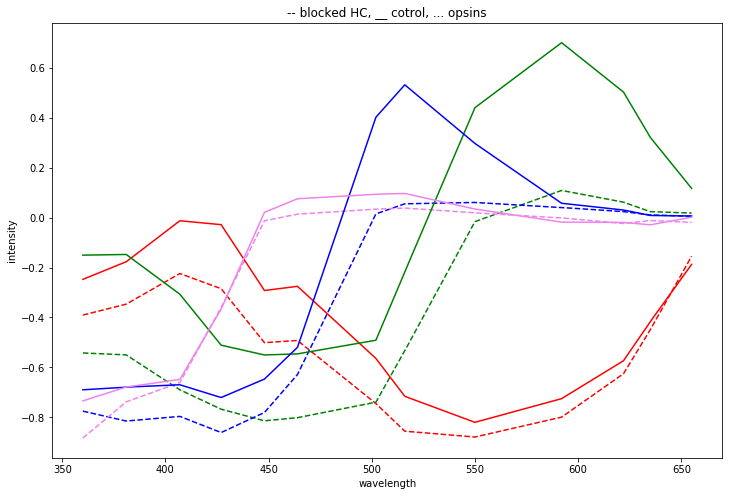

In [4]:
colors = ['r', 'g', 'b','violet' ]


plt.figure(figsize=(12,8))

plt.title('-- blocked HC, __ cotrol, ... opsins')
for i in range(4):
    plt.plot(wavelength, wave_blocked_raw[i], '--', color=colors[i], label='blocked')
    #plt.plot(wavelength, opsins[i], ':', color=colors[i], label='opsins')


for i in range(4):
    plt.plot(wavelength, wave_control_raw[i], color=colors[i], label='control condition')

plt.ylabel('intensity')
plt.xlabel('wavelength')
#plt.legend()

In [4]:
"""
load zone specific data
"""

filepath = '../data/all_cone_recordings/csvs/'
filenames = ['R-Cone recordings - control_merged.csv',
            'G-Cone recordings - control_merged.csv',
            'B-Cone recordings - control_merged.csv',
            'U-Cone recordings - control_merged.csv']

df_zones = pd.DataFrame()
for item in filenames:
    print(item)
    filename = filepath + item
    df1 = pd.read_csv(filename, sep=';',decimal=',')
    df_zones = df_zones.append(df1)


# convert to floats
for item in df_zones.columns[:13]:
    df_zones[item] = (df_zones[item].replace(',','.', regex=True).astype(float))
    

# load LED wavelenghts
filename = filepath + 'LED wavelength.csv'
led_wavelength =  pd.read_csv(filename, sep=';',decimal=',')
   
    
    
    
"""
preprocess data
"""
zones = ['SZ','Nasal','Dorsal','Ventral']

control_regionwise = np.zeros((4,4,296))
control_all_new = np.zeros((4,296))


for region_nr, region in enumerate(zones):
    for cone_nr, cone_type in enumerate(['R','G','B','U']):

        # get data
        data = df_zones[(df_zones.region==region)&(df_zones.cone_type==cone_type)].values[:,:13]
        data_all = df_zones[(df_zones.cone_type==cone_type)].values[:,:13]

        # interpolate
        data = scp.interpolate.interp1d(led_wavelength.Wavelength.values,data.mean(0))(wavelength)
        data_all = scp.interpolate.interp1d(led_wavelength.Wavelength.values,data_all.mean(0))(wavelength)

        # normalize
        data = -data / np.max(abs(data))
        data_all = -data_all / np.max(abs(data_all))
        
        # put to dataframe
        control_regionwise[region_nr, cone_nr] = data
        control_all_new[cone_nr] = data_all





R-Cone recordings - control_merged.csv
G-Cone recordings - control_merged.csv
B-Cone recordings - control_merged.csv
U-Cone recordings - control_merged.csv


In [53]:
"""
and cone specifig HC_block
"""

filepath = '../data/all_cone_recordings/csvs/'
filenames = ['R-Cone recordings - HCblock - regions_merged.csv',
            'G-Cone recordings - HCblock - regions_merged.csv',
            'B-Cone recordings - HCblock - regions_merged.csv',
            'U-Cone recordings - HCblock - regions_merged.csv']
             
df_zones_block = pd.DataFrame()
for item in filenames:
    print(item)
    filename = filepath + item
    df1 = pd.read_csv(filename, sep=';',decimal=',')
    df_zones_block = df_zones.append(df1)


# convert to floats
for item in df_zones.columns[:13]:
    df_zones_block[item] = (df_zones_block[item].replace(',','.', regex=True).astype(float))
    
    
"""
preprocess data
"""
zones = ['SZ','Nasal','Dorsal','Ventral']

block_regionwise = np.zeros((4,4,296))
block_all_new = np.zeros((4,296))


for region_nr, region in enumerate(zones):
    for cone_nr, cone_type in enumerate(['R','G','B','U']):

        # get data
        data = df_zones_block[(df_zones_block.region==region)&(df_zones_block.cone_type==cone_type)].values[:,:13]
        data_all = df_zones_block[(df_zones_block.cone_type==cone_type)].values[:,:13]

        # interpolate
        data = scp.interpolate.interp1d(led_wavelength.Wavelength.values,data.mean(0))(wavelength)
        data_all = scp.interpolate.interp1d(led_wavelength.Wavelength.values,data_all.mean(0))(wavelength)

        # normalize
        
        data = -data -np.min(-data)
        data /= np.max(abs(data))
        
        data_all = -data_all  -np.min(-data_all)

        data_all /= np.max(abs(data_all))
        
        # put to dataframe
        block_regionwise[region_nr, cone_nr] = data
        block_all_new[cone_nr] = data_all


R-Cone recordings - HCblock - regions_merged.csv
G-Cone recordings - HCblock - regions_merged.csv
B-Cone recordings - HCblock - regions_merged.csv
U-Cone recordings - HCblock - regions_merged.csv


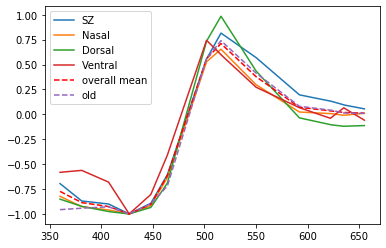

In [54]:
"""
see all regions for one type
"""
cone_type = 2
for i in range(4):
    plt.plot(wavelength, control_regionwise[i,cone_type], label=zones[i])
plt.plot(wavelength, 
         control_all_new[cone_type], 
         label='overall mean',
         color='red',ls='--')

plt.plot(wavelength,wave_normal[cone_type], ls='--', label='old')

plt.legend()

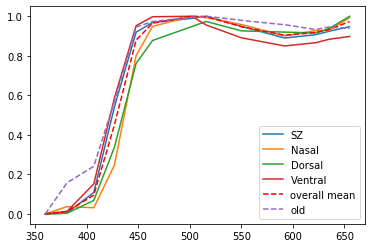

In [58]:
"""
see all regions for one type
"""
cone_type = 3
for i in range(4):
    plt.plot(wavelength, block_regionwise[i,cone_type], label=zones[i])
plt.plot(wavelength, 
         block_all_new[cone_type], 
         label='overall mean',
         color='red',ls='--')

plt.plot(wavelength,wave_blocked[cone_type], ls='--', label='old')

plt.legend()

In [59]:
"""
load model
"""

from hc_model import run_model_hc
from hc_model import extract_params


# specify modes
modes = [['HC0', 'HC1', 'HC2'],
 ['HC0', 'HC1'],
 ['HC0', 'HC2'],
 ['HC1', 'HC2'],
 ['HC0'],
 ['HC1'],
 ['HC2'],
 'special']



# number of params per mode
#mode_params = [11,8,7,7,4,4,3]
mode_params = [12,9,8,7,5,4,3,13]



In [7]:
"""
run without HC
"""

o = opsins

# connectivity pattern
# initialize by c for found connections
const = 1
w = np.zeros((3,4))
#w[0,0]= const
#w[0,1] = const
#w[0,2] = const
#w[1,1] = const
#w[1,2] = const
#w[1,3] = const
#w[2,2] = const
#w[2,3] = const

# synaptic (output) strength per HC (HC_j -> cone) (constant over the different cone types)
a = np.zeros(3)

# dark current (can also be seen as synaptic strength cone_i -> HC )
# fixed here
dc = np.ones(4)
#dc[0] = dc0
#dc[1] = dc1
#dc[2] = 0.5
#dc[3] = 2
    


k_no_HC = run_model_hc(wave_blocked,w, dc,a, N=200)

#loss_noHC = get_loss(k_data,k_no_HC)

In [8]:
k_no_HC.shape

(4, 296)

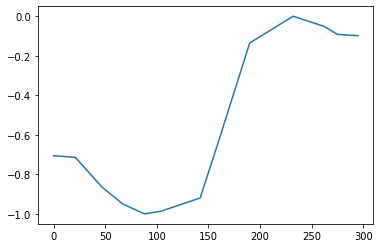

In [9]:
plt.plot(k_no_HC[1])

In [60]:
"""
!!!! model output is 4x296 !!!
"""

def run_model_x(params, o, mode, N=200):
    """
    helper to extract parameters
    and set params 0 if negative
    """
    
    w,dc,a = extract_params(params,mode)
    
    # set to 0 if negative
    w[w<0] = 0 
    dc[dc<0] = 0 
    a[a<0] = 0 
    
    
    k_fit = run_model_hc(o,w,dc,a,N=N)
    
    return k_fit #, baseline_store

"""
own generator class
"""

class myGenerator(BaseGenerator):
    def __init__(self, *args, gen_minibatch, **kwargs):
        super().__init__(*args, **kwargs)
        self.gen_minibatch = gen_minibatch

    def gen(self, *args, **kwargs):
        if 'minibatch' in kwargs:
            minibatch = kwargs.pop('minibatch')
        else:
            minibatch = self.gen_minibatch
        return super().gen(*args, minibatch=minibatch, **kwargs)


"""
Define simulator class
"""

class HC_Class(BaseSimulator):
    def __init__(self, simulator, opsins, mode, dim=1, seed=None):
        """
        Model of HC cone interaction in zebrafish
        Parameters
        ----------
        
        seed : int or None
            If set, randomness is seeded
        """
        super().__init__(dim_param=dim, seed=seed)
        self.opsins = opsins
        self.simulate1 = simulator 
        self.mode = mode
        
        
    def gen_single(self, params):
        """
        run one simulation of the model
        ------
        params : 1 dim array
        """        
        params = np.asarray(params).reshape(-1)
        assert params.ndim == 1
        assert params.shape[0] == self.dim_param


        sample = self.simulate1( params, self.opsins, self.mode)

        return {'data': sample.reshape(-1)}

    def run_parallel(self, *params):
        """
        runs simNormalized in a for loop, with n = len(params)
        to be used in multiprocessing - starmap
        """
        #print(len(params))
        result = []
        for i in range(0,len(params)):
            result_single = self.simulate1(params[i], self.opsins, self.mode)
            result.append({'data':result_single.reshape(-1)})
        return result
    
    '''    
    # from base class
    def gen(self, params_list, n_reps=1, pbar=None):
        """Forward model for simulator for list of parameters
        Parameters
        ----------
        params_list : list of lists or 1-d np.arrays
            List of parameter vectors, each of which will be simulated
        n_reps : int
            If greater than 1, generate multiple samples given param
        pbar : tqdm.tqdm or None
            If None, will do nothing. Otherwise it will call pbar.update(1)
            after each sample.
        Returns
        -------
        data_list : list of lists containing n_reps dicts with data
            Repetitions are runs with the same parameter set, different
            repetitions. Each dictionary must contain a key data that contains
            the results of the forward run. Additional entries can be present.
        """
        data_list = []
        for param in params_list:
            rep_list = []
            for r in range(n_reps):
                rep_list.append(self.gen_single(param))
            data_list.append(rep_list)
            if pbar is not None:
                pbar.update(1)

        return data_list
    '''
        

    
    
    # adapted gen for parallel processing
    # n_reps > 1 not yet implemented!!!
    def gen(self, params_list, n_reps=1, pbar=None, verbose = False, skip_feedback=False, prior_mixin=0,
            minibatch=100, keep_data=True, from_prior=False,):
        """Forward model for simulator for list of parameters
        Parameters
        ----------
        params_list : list of lists or 1-d np.arrays
            List of parameter vectors, each of which will be simulated
        n_reps : int
            If greater than 1, generate multiple samples given param
                TODO: not yet implemented in parallel run!!!
        pbar : tqdm.tqdm or None
            If None, will do nothing. Otherwise it will call pbar.update(1)
            after each sample.
        Returns
        -------
        data_list : list of lists containing n_reps dicts with data
            Repetitions are runs with the same parameter set, different
            repetitions. Each dictionary must contain a key data that contains
            the results of the forward run. Additional entries can be present.
        """
        # specify used cpus (should be intelligently chosen to minibatchsize)
        pr = 41 # 26
        
        # calc runs per cpu (last cpu is left for remainder of division)
        singlejobs = round(np.shape(params_list)[0]/(pr-1))
        
        # reshape params_list
        fitparams = list([])
        for i in range(0,pr-1):
            fitparams.append(params_list[i*singlejobs:(i+1)*singlejobs])
        fitparams.append(params_list[(i+1)*singlejobs:])
        # runs parallel the simulations
        with multiprocessing.Pool(processes=pr) as pool:
            JexoMult = pool.starmap(self.run_parallel, fitparams)
        
        
        
        # reshape the simulated data
        data_list = []
        for i in range(np.shape(JexoMult)[0]):
            for j in range(np.shape(JexoMult[i])[0]):
                rep_list = []
                rep_list.append(JexoMult[i][j])
                data_list.append(rep_list)
                if pbar is not None:
                    pbar.update(1)
                
        return data_list

    
    


"""
create summary statistics
"""

def mse(fit, data):
    """
    compute sqrt(mse)!!!
    """
    #mse = 1/(np.shape(data)[0]*np.shape(data)[1]) * np.sum((data - fit)**2)
    mse =  np.mean((data - fit)**2) # * 1/(len(data)) 
    #if mse >20:
    #    mse = 100
    if np.isnan(mse):
        #raise Warning('mse is Nan. Check your model.')
        return 10e3
    else:
        return min(np.sqrt(mse), 10e3)

class MseSS(BaseSummaryStats):
    """
    Reduces data to mse
    """

    def __init__(self, data, seed=None):
        super().__init__(seed=seed)
        # should return a matrix n_samples x 1 (mse)
        self.n_summary = 1
        self.data = data

    @copy_ancestor_docstring
    def calc(self, repetition_list):
        # See BaseSummaryStats.py for docstring

        # get the number of repetitions contained
        n_reps = len(repetition_list)

        # build a matrix of n_reps x 1
        repetition_stats_matrix = np.zeros((n_reps, self.n_summary))

        # for every repetition, take the mean of the data in the dict
        for rep_idx, rep_dict in enumerate(repetition_list):
            repetition_stats_matrix[rep_idx, ] = mse(rep_dict['data'], self.data)

        return repetition_stats_matrix
    
    
    


In [61]:
class DELFI_HC():
    def  __init__(self, opsins, mode,  nparams, recorded_data):
        self.opsins = opsins
        self.mode = mode
        self.nparams = nparams
        self.recorded_data = recorded_data
    
    def initialize_model(self, prior):
        """initialize model"""
            
        # define prior
        if prior =='gauss':
            mean_start = np.ones(self.nparams)#*0.5
            self.prior = dd.Gaussian(m = mean_start , S=np.eye(self.nparams)*0.25)
            
        elif prior == 'uniform':
            self.prior = dd.Uniform(lower= np.zeros(nparams), upper= np.ones(nparams)*3)
        else:
            raise NameError('This prior is not yet implemented.')
        
        
        # initialize summary statistics 
        self.s = MseSS(self.recorded_data) 
        
        # initialize model
        self.m = HC_Class(run_model_x, self.opsins, self.mode, dim=self.nparams)
        self.generator = myGenerator(model= self.m, prior= self.prior, summary=self.s, gen_minibatch=1000) 
        #BaseGenerator(model= self.m, prior= self.prior, summary=self.s)
     
        
        
        
        
        ##########################################################################################
        
    def infer_params(self, rounds, n_train, x0 = None,
                     save=True, filename = None, 
                     bw=1, q=None):

        """
        run the inference algorithme in mulitple rounds
        ---
        params:
        : rounds:    number of rounds
        : nr_train:  number of samples per round (int or list of int) [100000, 10000]
        : bw:        bandwidht of Gauss-kernel
        """
        
        folderpath = '/gpfs01/berens/user/cschroeder/Documents/Biophysical Models/Cone_HC_interaction/Delfi/fit_results/regionwise/'

        
        # raise error if no filename is specified
        if save:
            if filename == None:
                raise NameError('No filename for saving specified.')
                
            filelist = os.listdir(folderpath)
            
            if filename in filelist:
                raise NameError('Filename already exists.')
        
        # observed data 
        xo = x0 #np.array([x0])

        starttime = datetime.datetime.now()
        print('Starting time for inference:', starttime)

        # set kernel
        bandwidth = 0.5
        kernel = delfi.kernel.StrechedGauss(xo, bandwidth=bandwidth) 
        
        # initialize
        inf_snpe = SNPE(generator=self.generator,
                        prior_mixin=0, # mix additional N*prior_mixin samples into samples from proposal prior
                        n_components=3, 
                        n_hiddens=[100,100], 
                        obs=xo,
                        pseudo_obs_perc= 0.01, 
                        pseudo_obs_n= None,
                        pseudo_obs_dim = 0,
                        kernel_bandwidth_perc=20,
                        kernel_bandwidth_n= None,
                        kernel_bandwidth_min=None,
                        pseudo_obs_use_all_data= False,
                        pilot_samples=None, 
                        kernel=kernel, 
                        svi=False,
                        reg_lambda=0.01, # precision parameter in svi, default 0.01
                        impute_missing=True,
                        init_trn_data_folder= mode,#'flashtds',
                        verbose=True) 
        
        #if changing_obs:
        #    if not len(x0)==rounds:
        #        raise NameError('length of x0  does not match the number of rounds.')
                
        
        # returning loss of DNN, (params, simulations), posteriors (for each round)
        logs, tds, posteriors = inf_snpe.run(n_train=n_train, 
                                             n_rounds=rounds, 
                                             proposal = self.prior, 
                                             epochs= 600,#800, 
                                             minibatch= 500, #500 
                                             stop_on_nan=True,
                                             monitor= None,  #{'missing':missing}, ????
                                             round_cl=2) #init_trn_data_folder= 'flashtds_decay_singlerise_D1',
        

        runtime = datetime.datetime.now() - starttime
        print('Runtime: ',runtime, ' in total' )
        print()


        if save:
            """
            saving the posteriors
            """
            filepath = folderpath+filename
            info = '{} rounds, n_train = {} , SNPE, n_components=3, n_hiddens=[100,100],obs={}, 0.01pseudo_obs \
            pilot_samples=None, 600 epochs, minibatch=500, gauss prior,prior_mixin=0, bandwidth=20p, svi=False\
            kernel=gauss,SS=MSE, runtime: {:.5} min. prior=1,eye*0.25 '.format(rounds, samples,x0,runtime.total_seconds()/60)
           
            
            saveobject = dict({'posterior': posteriors, 
                   'logs':logs,
                   'SNPE_info': info,
                  'tds':tds,
                 'model':inf_snpe,
                  'mode':mode})
            pickle.dump( saveobject, open(filepath, "wb" ) )

        return logs, tds, posteriors, inf_snpe

In [11]:
modes

[['HC0', 'HC1', 'HC2'],
 ['HC0', 'HC1'],
 ['HC0', 'HC2'],
 ['HC1', 'HC2'],
 ['HC0'],
 ['HC1'],
 ['HC2'],
 'special']

In [62]:
wave_blocked.shape

(4, 296)

In [63]:
block_regionwise.shape

(4, 4, 296)

In [66]:
"""
fit all modes
"""


errors =  []  
i=0
for region_nr in [2]:# range(4):
    try:
        # choose mode
        mode = modes[i]
        # define nr of params dependent on mode
        nparams = mode_params[i]

        # specify input data we want to fit
        input_data = np.copy(control_regionwise[region_nr]).flatten()

        # specify "cone output" (opsins)
        cone_out = block_regionwise[region_nr]# wave_blocked

        # get class (opsins, mode,  nparams, recorded_data):
        fit_model = DELFI_HC(cone_out, mode, nparams, input_data)

        # initialize class
        fit_model.initialize_model('gauss')


        ####################################
        filename = 'mode0_region_' + str(region_nr) + '_regionspecific_input_v0.pkl'

        x0 = np.array([[0]])
        rounds = 5
        samples = 200000
        logs, tds, posteriors, inf_snpe = fit_model.infer_params(rounds, samples, x0=x0, save=True, filename=filename)
    
    except Exception as error:
        errors.append(dict(region_nr=region_nr,error=error))

Starting time for inference: 2021-01-19 09:01:06.987136


/usr/local/lib/python3.8/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


	 200000 samples requested.
	Drawing 200000 parameter samples ... 
	Done after 9.016 min
	Training network with observed:
	 [0.271]
	and kernel bandwidth:
	 [0.431]
	Done after 10.79 min
	 200000 samples requested.
	Drawing 200000 parameter samples ... 
	Done after 12.23 min
	Training network with observed:
	 [0.148]
	and kernel bandwidth:
	 [0.275]
	Done after 11.06 min
	 200000 samples requested.
	Drawing 200000 parameter samples ... 
	Done after 12.15 min
	Training network with observed:
	 [0.124]
	and kernel bandwidth:
	 [0.257]
	Done after 11.27 min
	 200000 samples requested.
	Drawing 200000 parameter samples ... 
	Done after 12.17 min
	Training network with observed:
	 [0.119]
	and kernel bandwidth:
	 [0.244]
	Done after 11.28 min
	 200000 samples requested.
	Drawing 200000 parameter samples ... 
	Done after 12.14 min
	Training network with observed:
	 [0.14]
	and kernel bandwidth:
	 [0.261]
	Done after 11.12 min
Runtime:  1:53:39.314812  in total



In [65]:
errors

[{'modenr': 0,
  'error': numpy.linalg.LinAlgError('Matrix is not positive definite')}]

In [9]:
"""
fit one mode
"""
# choose mode
mode = special_mode[0] #modes[4]
# define nr of params dependent on mode
nparams = special_nrparmas #mode_params[4]

# specify input data we want to fit
input_data = np.copy(wave_normal).flatten()

# specify "cone output" (opsins)

cone_out = wave_blocked

# get class (opsins, mode,  nparams, recorded_data):
fit_model = DELFI_HC(cone_out, mode, nparams, input_data)

# initialize class
fit_model.initialize_model('gauss')


####################################
filename = 'mode_specialH0full_0.pkl'

x0 = np.array([[0]])
rounds = 10
samples = 100000
logs, tds, posteriors, inf_snpe = fit_model.infer_params(rounds, samples, x0=x0, save=True, filename=filename)

Starting time for inference: 2019-10-23 07:19:08.612308
	Round: 1 of 10. 	 Network training round: 1
	Sampling 100000 samples ... 



	Done after 4.034 min
	Training network with observed = 0.15 and bw = 0.1 ... 


	Done after 4.027 min
	Round: 2 of 10. 	 Network training round: 2
	Sampling 100000 samples ... 



	Done after 5.053 min
	Training network with observed = 0.13 and bw = 0.019 ... 


	Done after 4.346 min
	Round: 3 of 10. 	 Network training round: 3
	Sampling 100000 samples ... 



	Done after 5.151 min
	Training network with observed = 0.13 and bw = 0.0019 ... 


	Done after 4.087 min
	Round: 4 of 10. 	 Network training round: 4
	Sampling 100000 samples ... 



	Done after 5.153 min
	Training network with observed = 0.13 and bw = 0.00046 ... 


	Done after 4.043 min
	Round: 5 of 10. 	 Network training round: 5
	Sampling 100000 samples ... 



	Done after 5.224 min
	Training network with observed = 0.13 and bw = 0.00022 ... 


	Done after 4.445 min
	Round: 6 of 10. 	 Network training round: 6
	Sampling 100000 samples ... 



	Done after 5.245 min
	Training network with observed = 0.13 and bw = 0.00016 ... 


	Done after 4.229 min
	Round: 7 of 10. 	 Network training round: 7
	Sampling 100000 samples ... 



	Done after 5.18 min
	Training network with observed = 0.13 and bw = 0.00074 ... 


	Done after 4.213 min
	Round: 8 of 10. 	 Network training round: 8
	Sampling 100000 samples ... 



	Done after 5.271 min
	Training network with observed = 0.13 and bw = 0.0012 ... 


	Done after 4.146 min
	Round: 9 of 10. 	 Network training round: 9
	Sampling 100000 samples ... 



	Done after 5.306 min
	Training network with observed = 0.13 and bw = 0.00068 ... 


	Done after 4.298 min
	Round: 10 of 10. 	 Network training round: 10
	Sampling 100000 samples ... 



	Done after 5.316 min
	Training network with observed = 0.13 and bw = 0.00071 ... 


	Done after 4.393 min
Runtime:  1:33:43.247481  in total



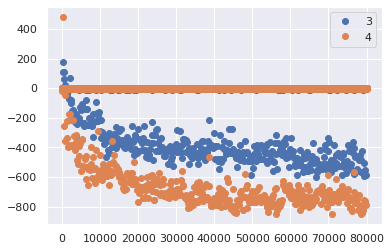

In [33]:
"""
plot loss of training
"""
# only plot every filterns elt
filtern = 1
for i in range(3,5):
    plt.plot(logs[i]['loss'][::filtern],'o', label = i)
    #plt.ylim(-0.1,0.2)
    plt.legend()
plt.show()

Text(0.5, 0, 'round')

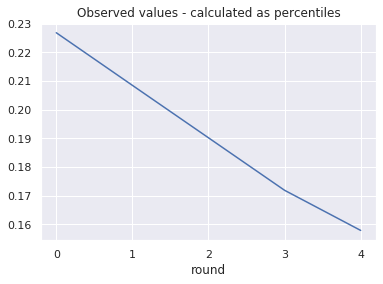

In [35]:
"""
plot pseudo observations
"""

# nr of rounds
n = 5

plt.title('Observed values - calculated as percentiles')

plt.plot(np.arange(0,n),np.array(inf_snpe.pseudo_obs).flatten(), label='run 1')

#plt.ylim(-0.1,3.5)
#plt.legend()
plt.xticks(np.arange(0,n))
plt.xlabel('round')
#plt.ylim(0)
